In [159]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [168]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


def show_confusion_matrix(y_true, y_pred, classes):    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

In [122]:
dataset = load_dataset("dair-ai/emotion")
train = dataset['train']
val = dataset['validation']
test = dataset['test']


In [123]:
def get_posts(data):
    posts = [x ['text'] for x in data]
    labels = [x ['label'] for x in data]
    return posts, labels


In [124]:
def get_sequences(tokenizer, tweets, maxlen):
  # making all sequences same length
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, 
    truncating = 'post', 
    padding='post', 
    maxlen=maxlen)
  return padded

In [125]:
train_posts, train_labels = get_posts(train)
train_posts[0], train_labels[0]

('i didnt feel humiliated', 0)

In [126]:
unique_elements = set(train_labels)

# Convert the set back to a list if needed
unique_elements_list = list(unique_elements)

print(unique_elements_list)

[0, 1, 2, 3, 4, 5]


In [127]:
token = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<UNK>')
token.fit_on_texts(train_posts)

In [128]:
token.fit_on_texts(train_posts)
print(train_posts[0])

token.texts_to_sequences([train_posts[0]])    

i didnt feel humiliated


[[2, 139, 3, 679]]

In [129]:
training_sequences = get_sequences(token, train_posts, 50)
training_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [152]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
              

In [153]:
validation_posts, validation_labels = get_posts(val)
validation_sequences = get_sequences(token, validation_posts, 50)

In [154]:

history = model.fit(
    np.array(training_sequences), np.array(train_labels),
    validation_data=(np.array(validation_sequences), np.array(validation_labels)),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )                               

Epoch 1/20
500/500 [==============================] - 21s 23ms/step - loss: 1.4059 - accuracy: 0.3758 - val_loss: 1.1413 - val_accuracy: 0.4480
Epoch 2/20
500/500 [==============================] - 11s 21ms/step - loss: 0.7445 - accuracy: 0.7153 - val_loss: 0.6256 - val_accuracy: 0.7920
Epoch 3/20
500/500 [==============================] - 11s 21ms/step - loss: 0.4298 - accuracy: 0.8571 - val_loss: 0.5452 - val_accuracy: 0.8140
Epoch 4/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2985 - accuracy: 0.9040 - val_loss: 0.4615 - val_accuracy: 0.8430
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2688 - accuracy: 0.9115 - val_loss: 0.5674 - val_accuracy: 0.8350
Epoch 6/20
500/500 [==============================] - 12s 23ms/step - loss: 0.1932 - accuracy: 0.9383 - val_loss: 0.4364 - val_accuracy: 0.8645
Epoch 7/20
500/500 [==============================] - 13s 25ms/step - loss: 0.1394 - accuracy: 0.9579 - val_loss: 0.4090 - val_accuracy:

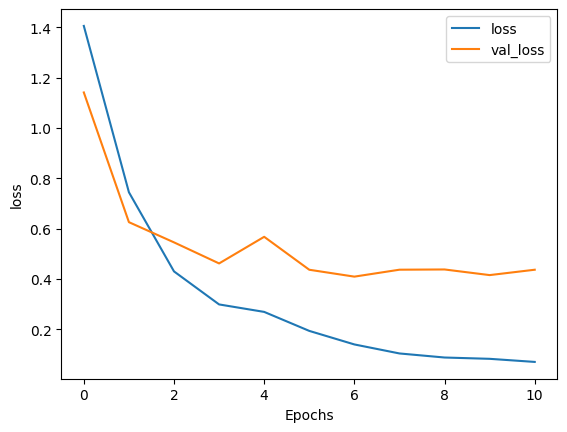

In [155]:
plot_graphs(history, 'loss')

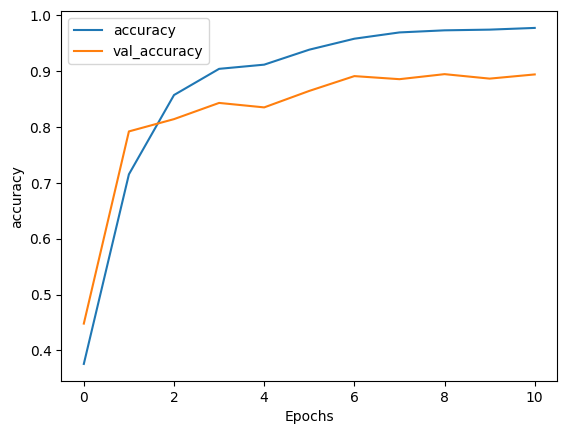

In [156]:
plot_graphs(history, 'accuracy')

In [161]:
test_posts, test_labels = get_posts(test)
test_sequences = get_sequences(token, test_posts, 50)

model.evaluate(np.array(test_sequences), np.array(test_labels))

63/63 [==============================] - 1s 8ms/step - loss: 0.4862 - accuracy: 0.8755


[0.48615142703056335, 0.8755000233650208]

In [166]:
predictions = model.predict(np.array(test_sequences))


63/63 [==============================] - 1s 8ms/step


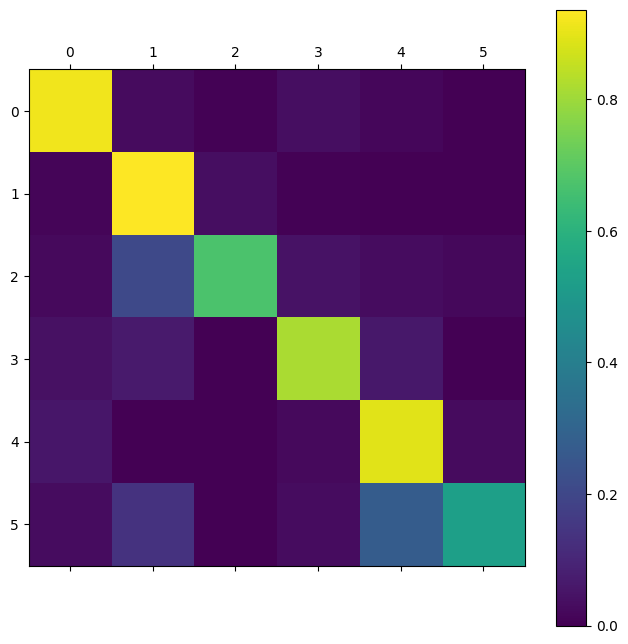

In [169]:
show_confusion_matrix(test_labels, np.argmax(predictions, axis=1), unique_elements_list)